In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

In [2]:
N_EPOCHS = 2    # number of epochs of training
BATCH_SIZE = 50   # size of the batches
LR = 1e-5         # adam: learning rate
B1 = 0.5          # adam: decay of first order momentum of gradient
B2 = 0.999        # adam: decay of first order momentum of gradient

N_CPU = 11         # number of cpu threads to use during batch generation
LATENT_DIM = 100  # dimensionality of the latent space
IMG_SIZE = 28     # size of each image dimension
CHANNELS = 1      # number of image channels
SAMPLE_INTERVAL = 100 # interval betwen image samples

In [3]:
img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)
torch.manual_seed(12345)
cuda = True if torch.cuda.is_available() else False
print("CUDA:", cuda)

CUDA: False


In [150]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(LATENT_DIM, 128)
        self.fc2 = nn.Linear(128, 7 * 7 * 64)
        
        # initializing weights (maybe biases will be added later as well)
        self.scaled_mats = torch.normal(0, 1, size=(2, 7, 7, 4, 4), requires_grad=True)
        self.scaled_mats = self.scaled_mats.view(1, 2, 7, 7, 4, 4)
        self.scaled_mats = torch.repeat_interleave(self.scaled_mats, 64, dim=1)
        
        self.scaled_mats_bias = torch.normal(0, 1, size=(2, 7, 7, 4, 4), requires_grad=True)
        self.scaled_mats_bias = self.scaled_mats_bias.view(1, 2, 7, 7, 4, 4)
        self.scaled_mats_bias = torch.repeat_interleave(self.scaled_mats_bias, 64, dim=1)
        
        self.imag_weights = torch.normal(0, 1, size=(64 * 2, 1), requires_grad=True).view(1, 128, 1, 1)
        
        self.imag_weights_bias = torch.normal(0, 1, size=(64 * 2, 1), requires_grad=True).view(1, 128, 1, 1)
        
    def tt(self, m, n, i, j):
        t1 = torch.arange(0, m * n, i * j).view(int(m / i), int(n / j)).repeat_interleave(i, dim=0).repeat_interleave(j, dim=1)
        t2 = torch.arange(i * j).view(i, j).repeat(int(m / i), int(n / j))
        return (t1 + t2).view(m * n)

    def forward(self, z):
        
        flat_z = F.leaky_relu(self.fc1(z))
        flat_z = F.leaky_relu(self.fc2(flat_z))
        
        small_imgs = flat_z.view(flat_z.size(0), 64, 7, 7, 1, 1)
        small_imgs = small_imgs.repeat(1, 2, 1, 1, 1, 1)
        
        big_imgs = torch.mul(self.scaled_mats, small_imgs)
        big_imgs = torch.add(self.scaled_mats_bias, big_imgs)
        big_imgs = big_imgs.view(BATCH_SIZE, 128, 7 * 4 * 7 * 4).transpose(0, -1)
        big_imgs = big_imgs[self.tt(28, 28, 4, 4)].transpose(0, -1)
        big_imgs = F.leaky_relu(big_imgs.view(BATCH_SIZE, 128, 7 * 4, 7 * 4))
        
        weighted_img = torch.add(torch.mul(big_imgs, self.imag_weights), self.imag_weights_bias)
#         weighted_img = F.softmax(torch.sum(weighted_img, dim=1))
        weighted_img = torch.tanh(torch.sum(weighted_img, dim=1))

        return weighted_img.view(weighted_img.size(0), *img_shape)


In [144]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
#         print("validity:\n", validity)
#         print(validity.shape)
        return validity

In [145]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [146]:
# Configure data loader
# os.makedirs("../PyTorch/MNIST", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(IMG_SIZE), 
                transforms.ToTensor(), 
                transforms.Normalize([0.5], [0.5])
            ]
        ),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [147]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

gen_imgs:  torch.Size([50, 1, 28, 28])
scaled_mats:  torch.Size([1, 128, 7, 7, 4, 4])


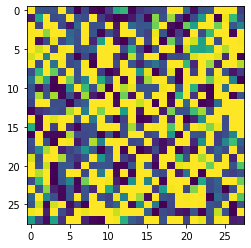

In [155]:
z = Variable(Tensor(np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))))

generator = Generator()
gen_imgs = generator(z)
plt.imshow(gen_imgs[0][0].detach().numpy())
print("gen_imgs: ", gen_imgs.size())
print("scaled_mats: ", generator.scaled_mats.size())

In [149]:
for epoch in range(N_EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], LATENT_DIM))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward(retain_graph=True)
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % SAMPLE_INTERVAL == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            print(
                "[Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (batches_done, len(dataloader)*N_EPOCHS, d_loss.item(), g_loss.item())
            ) 
    print(
            "--- [Epoch %d/%d] [D loss: %f] [G loss: %f] ---"
            % (epoch, N_EPOCHS, d_loss.item(), g_loss.item())
        )

[Batch 0/2400] [D loss: 0.731780] [G loss: 0.645129]
[Batch 100/2400] [D loss: 0.164634] [G loss: 2.115231]
[Batch 200/2400] [D loss: 0.040977] [G loss: 3.462831]
[Batch 300/2400] [D loss: 0.017040] [G loss: 4.363126]


KeyboardInterrupt: 

In [ ]:
save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)